In [1]:
import numpy as np
import PIL
import random
from IPython.core.display import Image, display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import copy

import math

import matplotlib.pyplot as plt

torch.manual_seed(2)
np.random.seed(2)

# правильно выбирайте карту, иначе все упадет!
CUDA_DEVICE=0

def data2image(data):
    res = np.transpose(np.reshape(data ,(3, 32,32)), (1,2,0))
    return PIL.Image.fromarray(np.uint8(res))

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [2]:
class CustomC100Dataset(data.Dataset):
    def __init__(self, dataset_path, dataset_type, img_cnt = 50000, transform = None, target_transform = None):
        if dataset_type not in ['train', 'train_95', 'test_2', 'train_98', 'test', 'test_5']:
            raise "Unknown dataset type : {}".format(dataset_type)
        self.ds_type = dataset_type
        self.ds_path = dataset_path
        self.img_cnt = img_cnt
        self.transform = transform
        self.t_transform = target_transform
        self.__load__()
    
    def __load__(self):
        dataset = np.load(self.ds_path)
        if self.ds_type == 'train':
            dataset = dataset.reshape((self.img_cnt,3073))
            self.y, self.x = np.hsplit(dataset, [1])
            self.y = self.y.astype(np.int64)
            self.x = self.x.reshape((self.x.shape[0],3,32,32))
            self.x = self.x.transpose((0, 2, 3, 1))

        if self.ds_type == 'train_95':
            train_mask = (np.array(range(dataset.shape[0])) % 20) != 0
            dataset = dataset[train_mask]
            self.y, self.x = np.hsplit(dataset, [1])
            dataset = dataset.reshape((dataset.shape[0],3073))
            self.y = self.y.astype(np.int64)
            self.x = self.x.reshape((self.x.shape[0],3,32,32))
            self.x = self.x.transpose((0, 2, 3, 1)) 
            
        if self.ds_type == 'test_5':
            test_mask = ((np.array(range(dataset.shape[0])) % 20) == 0)
            dataset = dataset[test_mask]
            self.y, self.x = np.hsplit(dataset, [1])
            dataset = dataset.reshape((dataset.shape[0],3073))
            self.y, self.x = np.hsplit(dataset, [1])
            self.y = self.y.astype(np.int64)
            self.x = self.x.reshape((self.x.shape[0],3,32,32))
            self.x = self.x.transpose((0, 2, 3, 1))
            
        if self.ds_type == 'train_98':
            train_mask = (np.array(range(dataset.shape[0])) % 50) != 0
            dataset = dataset[train_mask]
            self.y, self.x = np.hsplit(dataset, [1])
            dataset = dataset.reshape((dataset.shape[0],3073))
            self.y = self.y.astype(np.int64)
            self.x = self.x.reshape((self.x.shape[0],3,32,32))
            self.x = self.x.transpose((0, 2, 3, 1)) 
            
        if self.ds_type == 'test_2':
            test_mask = ((np.array(range(dataset.shape[0])) % 50) == 0)
            dataset = dataset[test_mask]
            self.y, self.x = np.hsplit(dataset, [1])
            dataset = dataset.reshape((dataset.shape[0],3073))
            self.y, self.x = np.hsplit(dataset, [1])
            self.y = self.y.astype(np.int64)
            self.x = self.x.reshape((self.x.shape[0],3,32,32))
            self.x = self.x.transpose((0, 2, 3, 1))
    
    
        if self.ds_type == 'test':
            dataset = dataset.reshape((self.img_cnt,3072))
            self.y = np.zeros((dataset.shape[0], 1), dtype=np.int64)
            self.x = dataset.reshape((dataset.shape[0],3,32,32))
            self.x = self.x.transpose((0, 2, 3, 1))
    
    def __getitem__(self, index):
        img, target = self.x[index], self.y[index]
        
        img = PIL.Image.fromarray(img)
        
        if self.transform is not None:
            img = self.transform(img)

        if self.t_transform is not None:
            target = self.t_transform(target)
            
        return img, target

    
    def __len__(self):
        return len(self.x)

In [3]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation([-3,3]),
    transforms.RandomCrop(32,padding=4,padding_mode="reflect"),
    transforms.ToTensor(),
    transforms.Normalize([0.5074,0.4867,0.4411], [0.2011,0.1987,0.2025])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5074,0.4867,0.4411], [0.2011,0.1987,0.2025])
])

train_dataset = CustomC100Dataset('homework_2.train.npy', 'train', img_cnt = 50000, transform = transform_train)

train95_dataset = CustomC100Dataset('homework_2.train.npy', 'train_95', img_cnt = 50000, transform = transform_train)
test5_dataset = CustomC100Dataset('homework_2.train.npy', 'test_5', img_cnt = 50000, transform = transform_test)

train98_dataset = CustomC100Dataset('homework_2.train.npy', 'train_98', img_cnt = 50000, transform = transform_train)
test2_dataset = CustomC100Dataset('homework_2.train.npy', 'test_2', img_cnt = 50000, transform = transform_test)

test_nc_dataset = CustomC100Dataset('homework_2_no_classes.test.npy', 'test', img_cnt = 10000, transform = transform_test)

Проверяем, что данные разделены равномерно

In [4]:
unique, counts = np.unique(train98_dataset.y, return_counts = True)
counts

array([490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490,
       490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490,
       490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490,
       490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490,
       490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490,
       490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490,
       490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490,
       490, 490, 490, 490, 490, 490, 490, 490, 490])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


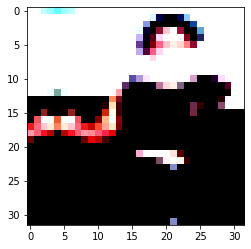

In [5]:
%matplotlib inline
img, label = train_dataset[4434]
imshow(img)

In [6]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [7]:
class BasicBlock(nn.Module):
    expansion=1

    def __init__(self,inplanes,planes,stride, downsample=None):
        # конструктор базового блока
        super(BasicBlock, self).__init__()
        
        # subblock 1
        first_layers = [nn.Conv2d(inplanes,planes[0],kernel_size=(1,1),stride=stride),
                    nn.BatchNorm2d(planes[0]),
                    nn.ReLU(inplace=True)]
        
        # subblock 2
        second_layers = [nn.Conv2d(planes[0],planes[1],kernel_size=(3,3),stride=(1,1),padding=1),
                    nn.BatchNorm2d(planes[1])]
        
        self.layers = nn.Sequential(*(first_layers + second_layers))
        self.relu = nn.ReLU(inplace = True)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        residual = x
        out = self.layers(x)
        
        if self.downsample is not None:
            residual = self.downsample(x)
            
        out += residual
        out = self.relu(out)
        
        return out

In [8]:
class BottleNeck(nn.Module):
    expansion=4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        
        super(BottleNeck, self).__init__()
        
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes)
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias = False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace = True)
        
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.downsample is not None:
            residual = self.downsample(x)
            
        out += residual
        out = self.relu(out)
        
        return out

In [10]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=100):
        
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.layer0 =self.stg1 = nn.Sequential(
                                   nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(3),stride=(1),padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(inplace=True),
                                   nn.MaxPool2d(kernel_size=3,stride=2))
        
        self.layer1 = self._make_layer(block, [64,256], 4,layers[0])
        self.layer2 = self._make_layer(block, [128,512], 2, layers[1], stride=2)
        self.layer3 = self._make_layer(block, [256,1024], 2, layers[2], stride=2)
        
        self.classifier = nn.Sequential(
                                       nn.AvgPool2d(kernel_size=(4)),
                                       nn.Flatten(),
                                       nn.Linear(1024,num_classes))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # инициализация параметров конволюции
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                
            elif isinstance(m, nn.BatchNorm2d):
                # инициализация параметров батч-нормализаций
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, factor, blocks, stride=1):
        downsample = nn.Sequential(conv1x1(self.inplanes, planes[1], stride))
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = self.inplanes * factor
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, 1))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.classifier(x)

        return x

In [11]:
# Выбирайте любой ResNet

def ResNet20():
    return ResNet(BasicBlock, [3,3,3], 100)

def ResNet32():
    return ResNet(BasicBlock, [5,5,5], 100)

def ResNet44():
    return ResNet(BasicBlock, [7,7,7], 100)

def ResNet50():
    return ResNet(BasicBlock, [3,4,6], 100)

def ResNet56():
    return ResNet(BasicBlock, [9,9,9], 100)

def ResNet56_BN():
    return ResNet(BottleNeck, [9,9,9], 100)

In [12]:
def acc_check(model, validation_loader, batch_size):
    model.eval()
    correct = 0.0
    total = 0.0
    
    for batch_idx, (inputs, labels) in enumerate(validation_loader):
        inputs, labels = inputs.cuda(), labels.view(batch_size).cuda()
        outputs = model(inputs)
        outputs = F.softmax(outputs)
        prob, predicted = torch.topk(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.view(-1).eq(labels.data).sum()
        
    model.train()
    return (correct / total)

In [13]:
def make_solution_pytorch(model, test_data_loader, batch_size):
    res = []
    model.eval()
    for batch_idx, (inputs, labels) in enumerate(test_data_loader):
        inputs, labels = inputs.cuda(), labels.view(batch_size).cuda()
        outputs = model(inputs)
        outputs = F.softmax(outputs)
        prob, predicted = torch.topk(outputs.data, 1)
        res = np.append(res, predicted.view(-1).cpu().numpy())
    model.train()
    return res

In [14]:
def plot_init():
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    return fig, (ax1, ax2, ax3, ax4)

def plot_loss_acc(fig, sbplts, tst_loss, tst_acc, trn_loss, trn_acc):
    epoch = len(tst_loss) - 1
    
    sbplts[0].plot(range(epoch+1), trn_loss, 'r-')
    sbplts[0].set_title('Train loss')
    sbplts[0].set_xlabel('Epoch')
    fig.canvas.draw()
        
    sbplts[1].plot(range(epoch+1), tst_loss, 'r-')
    sbplts[1].set_title('Test loss')
    sbplts[1].set_xlabel('Epoch')
    fig.canvas.draw() 
        
    sbplts[2].plot(range(epoch+1), trn_acc, 'g-')
    sbplts[2].set_title('Train accuracy')
    sbplts[2].set_xlabel('Epoch')
    fig.canvas.draw()
        
    sbplts[3].plot(range(epoch+1), tst_acc, 'g-')
    sbplts[3].set_title('Test accuracy')
    sbplts[3].set_xlabel('Epoch')
    fig.canvas.draw()
    

In [15]:
def train(model, optimizer, criterion, scheduler):
    train_loss_sum = 0
    last_batch_idx = 0
    correct = 0.0
    total = 0.0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):        
        inputs, labels = inputs.cuda(), labels.view(minibatch_size).cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total += labels.size(0)
        train_loss_sum += loss.data * labels.size(0)
        loss.backward()
        
        nn.utils.clip_grad_value_(model.parameters(),0.1)
        
        optimizer.step()
        last_batch_idx = batch_idx
        
        scheduler.step()
        
        outputs = F.softmax(outputs)
        prob, predicted = torch.topk(outputs.data, 1)
        correct += predicted.view(-1).eq(labels.data).sum()
    
    train_loss =  train_loss_sum / total
    accuracy = correct / total
    
    return train_loss, accuracy

def check(model):
    model.eval()
    
    test_loss_sum = 0
    correct = 0.0
    total = 0.0
    for batch_idx, (inputs, labels) in enumerate(test_nc_loader):
        inputs, labels = inputs.cuda(), labels.view(test_batch_size).cuda()
        outputs = model(inputs)
        loss = cross_entropy(outputs, labels)
        test_loss_sum += loss.data * labels.size(0)
        last_batch_idx = batch_idx
        
        outputs = F.softmax(outputs)
        prob, predicted = torch.topk(outputs.data, 1)
        correct += predicted.view(-1).eq(labels.data).sum()
        total += labels.size(0)
        
    test_loss =  test_loss_sum / total
    accuracy = correct / total
        
    return test_loss, accuracy

<IPython.core.display.Javascript object>


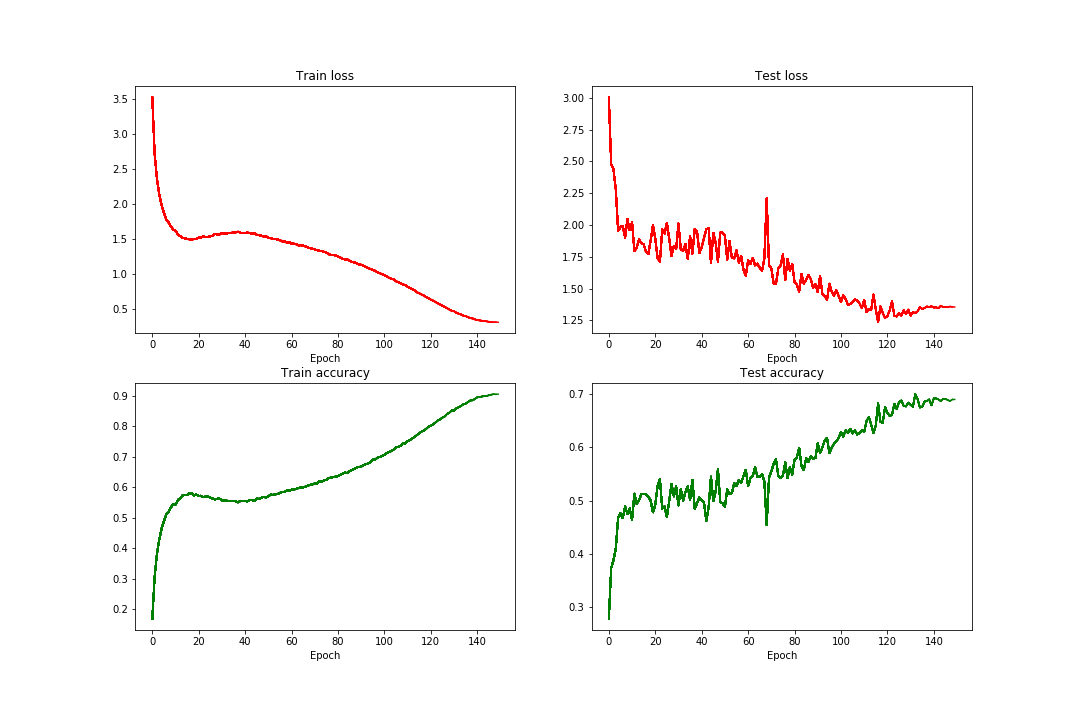

/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training


In [17]:
#Обучение ResNet
%matplotlib notebook
fig, sbplts = plot_init()
        
L_train_acc = [] # массив для хранения лоссов на обучении за эпоху
L_test_acc = [] # массив для хранения лоссов на отложенном сете
Acc_train_acc = [] # массив для хранения точности на обучении за эпоху
Acc_test_acc = [] # массив для хранения точности на отложенном сете за эпоху

model = ResNet50()
model.cuda(CUDA_DEVICE)

scheduler = torch.optim.lr_scheduler.OneCycleLR

#all parameters from https://arxiv.org/pdf/1512.03385.pdf
epochs_cnt = 150# кол-во эпох

minibatch_size = 250 
test_batch_size = 100

train_loader = torch.utils.data.DataLoader(train98_dataset, batch_size = minibatch_size, shuffle = True, num_workers = 2)
test_nc_loader = torch.utils.data.DataLoader(test2_dataset, batch_size = test_batch_size, shuffle = False, num_workers = 2)

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

max_lr = 0.01
optimizer = optim.Adam(model.parameters(), lr=max_lr, weight_decay=0.0001)# выбираем отимизатор 
scheduler = scheduler(optimizer,max_lr,epochs=epochs_cnt,steps_per_epoch=len(train_loader))

criterion = nn.CrossEntropyLoss().cuda(CUDA_DEVICE)
cross_entropy = F.cross_entropy

for epoch in range(epochs_cnt):
    model.train()
    
    cur_los, cur_acc = train(model, optimizer, criterion, scheduler)
    L_train_acc.append(cur_los)
    Acc_train_acc.append(cur_acc)
    
    cur_los, cur_acc = check(model)
    L_test_acc.append(cur_los)
    Acc_test_acc.append(cur_acc)
    
    if cur_acc > best_acc:
        best_acc = cur_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    
    plot_loss_acc(fig, sbplts, L_test_acc, Acc_test_acc, L_train_acc, Acc_train_acc)
    
model.load_state_dict(best_model_wts)

print('Finished Training')

In [18]:
# генерим решение вашей модели
test_nc_loader = torch.utils.data.DataLoader(test_nc_dataset, batch_size = test_batch_size, shuffle = False, num_workers = 2)
solution = make_solution_pytorch(model, test_nc_loader, test_batch_size)
with open('my_solution.csv', 'w') as fout:
    print('Id', 'Prediction', sep=',', file=fout)
    for i, prediction in enumerate(solution):
        print(i, int(prediction), sep=',', file=fout)

/home/e.remzin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
